In [15]:
from cgeniepy.ecology import EcoModel
import xarray as xr
from cgeniepy.array import GriddedData
from pathlib import Path
model_path = Path("../model")

## list all folders containing "EXP1'
exp3 = [str(x) for x in model_path.iterdir() if x.is_dir() and "EXP3" in x.name]
exp4 = [str(x) for x in model_path.iterdir() if x.is_dir() and "EXP4" in x.name]

m3 = EcoModel(exp3, gemflag=['biogem', 'ecogem'])
m4 = EcoModel(exp4, gemflag=['biogem', 'ecogem'])

In [16]:
#0.8 umol/kg


In [17]:
def postimpact_biomass(model, pft):    

    postimpact = model.get_pft(pft).isel(time=[-1]).mean(dim=['time', 'model']).array
    preimpact = model.get_pft(pft).isel(time=[0]).mean(dim=['time', 'model']).array
    survivor_ratio = postimpact / preimpact

    ## if preimpact is 0, set ratio to 0
    ratio = xr.where(preimpact == 0, 0, survivor_ratio)

    return GriddedData(ratio)

def temp_effect(variable):
    ## EXP3-EXP4
    return postimpact_biomass(m4, variable)

def food_effect(variable):
    ## -EXP3+EXP4+EXP5
    return postimpact_biomass(m3, variable) - temp_effect(variable)

0.000177
0.00372
9.75e-06


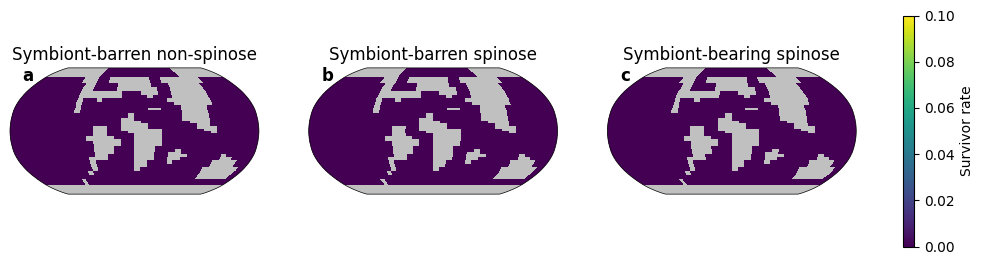

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, axs = plt.subplots(1,3,figsize=(12, 3), subplot_kw={'projection': ccrs.Robinson(central_longitude=-70)})

for i, pft in enumerate([16, 17, 19]):
    data = postimpact_biomass(m3, pft)
    ## biomass threshold
    threshold = m3.eco_pars()['q_C'][pft]
    print(threshold)
    data.array = xr.where(data.array > threshold, 0, data.array)
    data.aes_dict['pcolormesh_kwargs']['vmax'] = 0.1
    data.aes_dict['pcolormesh_kwargs']['vmin'] = 0.0
    data.aes_dict['pcolormesh_kwargs']['cmap'] = 'viridis'

    p = data.plot(ax=axs[i], colorbar=False)

## add colorbar
fig.colorbar(p, ax=axs, orientation='vertical', label='Survivor rate', fraction = 0.04)

## add titles
axs[0].set_title('Symbiont-barren non-spinose')
axs[1].set_title('Symbiont-barren spinose')
axs[2].set_title('Symbiont-bearing spinose')

## add alphabetical labels
for i, ax in enumerate(axs):
    ax.text(0.05, 0.9, chr(97+i), transform=ax.transAxes, size=12, weight='bold')

fig.savefig("../output/extinction rate.png", dpi=300, bbox_inches="tight")

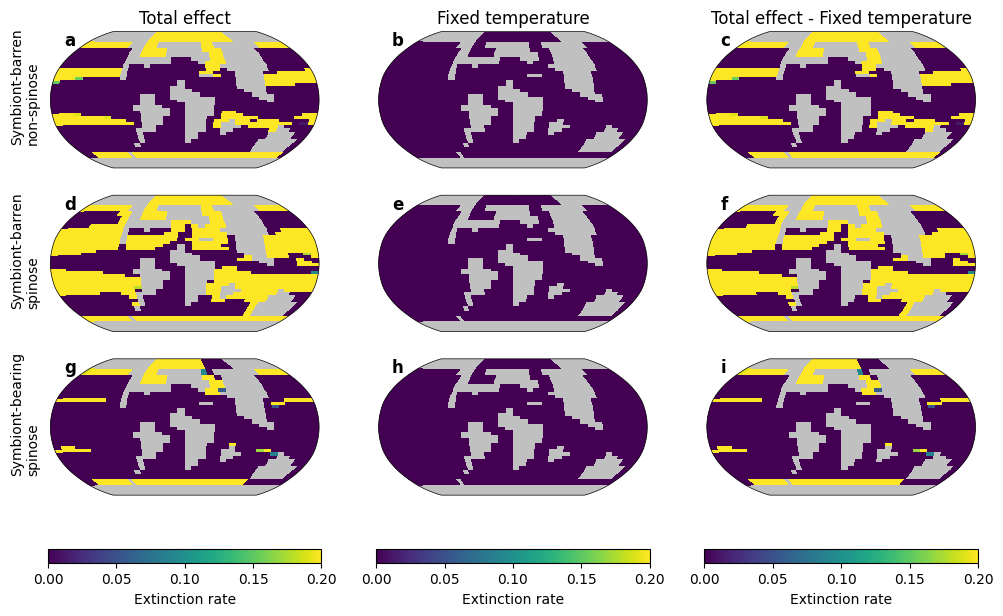

In [19]:
fig, axs = plt.subplots(3,3,figsize=(12, 7), subplot_kw={'projection': ccrs.Robinson(central_longitude=-70)})

## first column: temperature effect
for i, pft in enumerate([16, 17, 19]):
    data = postimpact_biomass(m3, pft)
    data.aes_dict['pcolormesh_kwargs']['vmax'] = 0.2
    data.aes_dict['pcolormesh_kwargs']['vmin'] = 0.0
    data.aes_dict['pcolormesh_kwargs']['cmap'] = 'viridis'

    p = data.plot(ax=axs[i, 0], colorbar=False)

    ## add titles
    if i == 0:
        axs[i, 0].set_title('Total effect')

fig.colorbar(p, ax=axs[:,0], orientation='horizontal', label='Extinction rate', fraction = 0.04, pad=0.1)

## second column: food effect
for i, pft in enumerate([16, 17, 19]):
    data = temp_effect(pft)
    data.aes_dict['pcolormesh_kwargs']['vmax'] = 0.2
    data.aes_dict['pcolormesh_kwargs']['vmin'] = 0.0
    data.aes_dict['pcolormesh_kwargs']['cmap'] = 'viridis'

    p = data.plot(ax=axs[i, 1], colorbar=False)

    ## add titles
    if i == 0:
        axs[i, 1].set_title('Fixed temperature')

fig.colorbar(p, ax=axs[:,1], orientation='horizontal', label='Extinction rate', fraction = 0.04, pad=0.1)

## third column: total effect
for i, pft in enumerate([16, 17, 19]):
    data = food_effect(pft)
    data.aes_dict['pcolormesh_kwargs']['vmax'] = 0.2
    data.aes_dict['pcolormesh_kwargs']['vmin'] = 0.0
    data.aes_dict['pcolormesh_kwargs']['cmap'] = 'viridis'

    p = data.plot(ax=axs[i, 2], colorbar=False)

    ## add titles
    if i == 0:
        axs[i, 2].set_title('Total effect - Fixed temperature')

fig.colorbar(p, ax=axs[:,2], orientation='horizontal', label='Extinction rate', fraction = 0.04, pad=0.1)    

## add alphabetical labels
for i, ax in enumerate(axs.flatten()):
    ax.text(0.05, 0.9, chr(97+i), transform=ax.transAxes, size=12, weight='bold')

## add row labels
labels = ['Symbiont-barren\nnon-spinose', 'Symbiont-barren\nspinose', 'Symbiont-bearing\nspinose']
for i, ax in enumerate(axs[:,0]):
    label = labels[i]
    ax.text(-0.15, 0.6, label, transform=ax.transAxes, rotation=90, fontdict={'fontsize': 10, 'fontweight': 'normal'}, va='center')

fig.savefig("../output/foram_driver.png", dpi=300, bbox_inches="tight")